# Continuous Control

---

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import pandas as pd

from ddpg_agent import Agent

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Check for the first brain available, and set it as the default brain.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Train

The next few cells will train the model

In [5]:
agent = Agent(state_size=state_size, agents=num_agents, action_size=action_size, random_seed=1)

In [6]:
def ddpg(episodes=1000, timesteps=1000, print_every=50):
    scores_deque = deque(maxlen=100)
    scores = []
    #start running through episodes
    for episode in range(1, episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  
        agent.reset()
        score = np.zeros(num_agents)
        # start running through timesteps
        for t in range(timesteps):
            # make actions based on env
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            
            # get next state
            next_states = env_info.vector_observations
            # update rewards
            rewards = env_info.rewards
            dones = env_info.local_done
            
            #step with agent
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break 
        # update scores
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        #print scores, save checkpoints
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), '.checkpoint_critic.pth')
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))
        # if avg above 30 over 100 episodes, we done
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores


In [7]:
scores = ddpg()

Episode 100	Average Score: 25.07
Episode 114	Average Score: 30.04
Environment solved in 14 episodes!	Average Score: 30.04


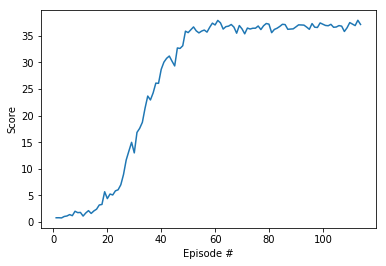

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [9]:
env.close()